In [17]:
from pylab import *
!pip install biopython


In [1]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

In [12]:
promotername = 'Scn1a_Mouse_Ensemble 2'

In [4]:
# Gibbs free energies of nearest-neighbors for TD stability calculations.
# From Wiki: Nucleic Acid Thermodynamics; primary source in footnote [1].
AAE = -4.26
ATE = -3.67
TAE = -2.5
CAE = -6.12
GTE = -6.09
CTE = -5.4
GAE = -5.51
CGE = -9.07
GCE = -9.36
GGE = -7.66

In [5]:
# Generalized fudge factor for floating-point comparisons.
fudge = 0.00000001

# end: the ends of the target are compared for thermodynamic stability. The
# variable 'end' is the number of nucleotides that are included in the
# definition of the ends of the target (same number of nucleotides are used for
# 3' and 5' ends). Should be an integer between 1 and 19 (more genenerally,
# between 1 and the length of the target).  Nominally (according to Schwarz et
# al., 2003), end should be around 4, since the siRNA duplex is unwound by
# a helicase that can 'see' about 4 bases at a time.
end = 4

# stab: the weighting factor for the relative stability of the 3' end of a
# target as compared to its 5' end. The more stable the 5' end is compared
# to the 3' end, the better. Should be a floating-point number >=0.
stab = 0.01

# ind18: the weighting factor for the presence of an A or a T at position 18 of
# the target sequence. A is better than T; this factor determines how much better.
# Should be a floating-point number >=0.
ind18 = 1000.

# ind7: the weighting factor for the presence of a T residue at position 7 of the
# target sequence. T is better than anything else; this factor determines how
# much better. Should be a floating-point number >=0.
ind7 = 1000.

# flank: the weighting factor for the presence of A or T residues at the 4
# nucleotides flanking the 3' end of a target sequence. At each of those
# positions, A or T are better than anything else; this factor determines how
# much better. Should be a floating-point number >=0.
flank = 1.


In [6]:
filepath = r'C:\\Users\\jvandevondervoort\\Finding sarnas'

In [7]:
def checksequence(sequence):
    sequence = sequence.upper()
    
    i = 0
    flag = True
    while i < len(sequence) and flag:
        if sequence[i] != 'A' and sequence[i] != 'G' and sequence[i] != 'C' and sequence[i] != 'T' and sequence[i] != 'U':
            flag = False
        i = i + 1

    if flag:
        sequence = sequence.replace('T','U')
    else:
        sequence = 'failure'
        
    return sequence

# Valid subroutine. Takes a sequence in the correct format and generates a list
# of all 19-base-long subsequences within that target. If the target length is
# n, then it generates n - 18 target subsequences, each with 19 nucleotides.

def maketargets(sequence):
    i = 0
    targets = []
    while i < len(sequence) - 18:
        targets = targets + [sequence[i:i + 19]]
        i = i + 1
    return targets

# Valid subroutine. Takes a target sequence (of any length) and calculates the
# proportion of nucleotides that are either G or C, then returns that
# number.

def countGC(target):
    i = 0
    GC = 0
    while i < len(target):
        if target[i] == 'G' or target[i] == 'C':
            GC = GC + 1
        i = i + 1

    GC = float(GC)
    GC = GC/len(target)
    return GC

# Valid subroutine. Checks whether a 22-nucleotide subsequence of a long
# sequence, starting at nucleotide 'position', includes a string of four or
# more consecutive identical bases.  If the answer is yes, it returns True,
# if no, it returns False.

def checkconsecutive(sequence,position):
    i = 4
    flag = False
    while i < 19 and flag == False:
        if sequence[position - 4 + i] == sequence[position - 3 + i] and sequence[position - 3 + i] == sequence[position - 2 + i] and sequence[position - 2 + i] == sequence[position - 1 + i] and sequence[position - 1 + i] == sequence[position + i]:
            flag = True

        i = i + 1

    return flag

# Valid subrountine.  Given a target sequence submitted 5' to 3', determines
# whether the 3' or 5' end base is more energetically stable.  If the 5' end
# is more stable, returns True (since this means that the 5' end of the guide
# strand is less stable); otherwise, returns False.

def endbase(target):
    if target[0] == 'A' or target[0] == 'U':
        energy = AAE/2
    elif target[0] == 'G' or target[0] == 'C':
        energy = GGE/2
    else:
        print ("")
        print ("Error: none of the stardard bases were detected.")

    E5prime = energy

    if target[-1] == 'A' or target[-1] == 'U':
        energy = AAE/2
    elif target[-1] == 'G' or target[-1] == 'C':
        energy = GGE/2
    else:
        print ("")
        print ("Error: none of the stardard bases were detected.")

    E3prime = energy

    if E3prime - E5prime > fudge:
        recog = True
    else:
        recog = False

    return recog

# Valid subroutine. Given a target sequence submitted 5' to 3', calculates the
# difference in the thermodynamic stabilities of the 3' and 5' ends using the
# nearest-neighbor method. Variable parameter: end (see top), which defines
# the number of nucleotides that make up the 3' end and the 5' end. The
# difference is 3' end energy - 5' end energy. All energies are negative values
# because the system is bound. It is desirable for the 5' end to be more stable
# than the 3' end. If the 5' end is more stable (energy more negative) than the
# 3' end, then the difference as defined by the program will be positive; this
# is the desirable condition.

def endstability(target):
    i = 0
    E5prime = 0.
    while i < end - 1:
        if target[i:i + 2] == 'AA' or target[i:i + 2] == 'UU':
            energy = AAE
        elif target[i:i + 2] == 'AU':
            energy = ATE
        elif target[i:i + 2] == 'UA':
            energy = TAE
        elif target[i:i + 2] == 'CA' or target[i:i + 2] == 'AC':
            energy = CAE
        elif target[i:i + 2] == 'GU' or target[i:i + 2] == 'UG':
            energy = GTE
        elif target[i:i + 2] == 'CU' or target[i:i + 2] == 'UC':
            energy = CTE
        elif target[i:i + 2] == 'GA' or target[i:i + 2] == 'AG':
            energy = GAE
        elif target[i:i + 2] == 'CG':
            energy = CGE
        elif target[i:i + 2] == 'GC':
            energy = GCE
        elif target[i:i + 2] == 'GG' or target[i:i + 2] == 'CC':
            energy = GGE
        else:
            print ("")
            print ("gError: none of the recognized nearest-neighbor pairings were detected.")
            
        E5prime = E5prime + energy
        i = i + 1

    i = len(target) - end
    E3prime = 0.
    while i < len(target) - 1:
        if target[i:i + 2] == 'AA' or target[i:i + 2] == 'UU':
            energy = AAE
        elif target[i:i + 2] == 'AU':
            energy = ATE
        elif target[i:i + 2] == 'UA':
            energy = TAE
        elif target[i:i + 2] == 'CA' or target[i:i + 2] == 'AC':
            energy = CAE
        elif target[i:i + 2] == 'GU' or target[i:i + 2] == 'UG':
            energy = GTE
        elif target[i:i + 2] == 'CU' or target[i:i + 2] == 'UC':
            energy = CTE
        elif target[i:i + 2] == 'GA' or target[i:i + 2] == 'AG':
            energy = GAE
        elif target[i:i + 2] == 'CG':
            energy = CGE
        elif target[i:i + 2] == 'GC':
            energy = GCE
        elif target[i:i + 2] == 'GG' or target[i:i + 2] == 'CC':
            energy = GGE
        else:
            print ("")
            print ("Error: none of the recognized nearest-neighbor pairings were detected.")

        E3prime = E3prime + energy 
        i = i + 1

# Note: we want the 3' end to have a lower TD stability than the 5' end. Since
# all the free energies added here are negative, that means that a POSITIVE
# value of stabilitydiff is what we want; the higher the positive value, the
# more stable the 5' end is than the 3' end.
    stabilitydiff = E3prime - E5prime
    return stabilitydiff

# Valid subroutine. Checks whether the given target has an 'A' at its 19th
# position. If it does, return True, else return False.

def checkpos19(target):
    flag = False
    if target[18] == 'A':
        flag = True
    return flag

# Valid subroutine. Checks whether the given target has an 'A' or a 'U' at its
# 18th position. If it has 'A', return 2; if 'U', return 1; if neither, return
# 0.

def checkpos18(target):
    indicator = 0
    if target[17] == 'A':
        indicator = 2
    elif target[17] == 'U':
        indicator = 1
    return indicator

# Valid subroutine. Checks whether the given target has a 'U' at its 7th
# position. If it does, return 1; else, return 0.

def checkpos7(target):
    indicator = 0
    if target[6] == 'U':
        indicator = 1
    return indicator

# Valid subroutine. Checks whether the four nucleotides immediately 3' of the
# end of a target sequence (beginning at nucleotide number 'position') are
# 'A' or 'U'; returns a score equal to the number of 'A' or 'U' instances
# found among these nucleotides.

def checkflanks(sequence,position):
    i = position + 19
    score = 0
    while i < position + 23:
        if sequence[i] == 'A' or sequence[i] == 'U':
            score = score + 1
        i = i + 1
    return score

# Valid subroutine. Finds CpG islands in a submitted sequence, using roughly
# the same algorithm as used by D. Takai and P. A. Jones. Briefly, a CpG
# island is any stretch of DNA >=200 nucleotides in length, in which the GC
# content is >50%, the CpG content (number of CG (ordered) pairs) is greater
# than 0.6 times the expected value of this content (expected value is
# calculated as (number of C)*(number of G)/(length of sequence)) and that
# contains at least 7 CpG sites (to avoid mathematical artefacts). The
# output of this subroutine differs slightly from that of the Takai/Jones
# program, since this one includes no minimum distance between consecutive
# islands.

def CpGislanddetector(sequence):
    if len(sequence) > 200:

        CpGverdicts = []
        GC = (sequence.count('G', 0, 200) + sequence.count('C', 0, 200))/200.
        CpG = sequence.count('CG', 0, 200)

        CpGexp = (sequence.count('C', 0, 200)*sequence.count('G', 0, 200))/200.

        if GC > 0.5 and CpG > 0.6*CpGexp and CpG > 7:
            CpGverdicts = CpGverdicts + [True]
        else:
            CpGverdicts = CpGverdicts + [False]

        i = 1
        
        while i < len(sequence) - 199:
            GCchange = 0
            if sequence[i - 1] == 'G' or sequence[i - 1] == 'C':
                GCchange = GCchange - 1
            if sequence[i + 199] == 'G' or sequence[i + 199] == 'C':
                GCchange = GCchange + 1
            GC = ((GC*200.) + GCchange)/200.
            CpGexp = (sequence.count('C',i, i + 200)*sequence.count('G',i, i + 200))/200.

            CpGchange = 0
            if sequence[i - 1] == 'C' and sequence[i] == 'G':
                CpGchange = CpGchange - 1
            if sequence[i + 198] == 'C' and sequence[i + 199] == 'G':
                CpGchange = CpGchange + 1
            CpG = CpG + CpGchange

            if GC > 0.5 and CpG > 0.6*CpGexp and CpG > 7:
                CpGverdicts = CpGverdicts + [True]
            else:
                CpGverdicts = CpGverdicts + [False]

            i = i + 1

        rawislandboundaries = []
        i = 0
        j = 0
        while i < len(CpGverdicts):
            if CpGverdicts[i]:
                rawislandboundaries = rawislandboundaries + [[]]
                rawislandboundaries[j] = rawislandboundaries[j] + [i, i + 199]
                j = j + 1
            i = i + 1

        if rawislandboundaries == []:
            islandboundaries = []
        else:    
            islandboundaries = [rawislandboundaries[0]]
            i = 0
            j = 0
            while i < len(rawislandboundaries):
                if rawislandboundaries[i][0] < islandboundaries[j][1]:
# Note: Python has a strange feature whereby assigning a list to a variable in a list (as in the case of
# [rawislandboundaries[0]] being assigned to islandboundaries above), the two lists are forever linked;
# that is, any variable assignment to one list is transitively ported to the other list as well. This
# means that the first entry corresponding to each "real" CpG island in the list rawislandboundaries will
# always be the full length of the real CpG island, whereas all the other entries in this list will
# correspond, as expected, to mini-CpG island windows of 200 bp.
                    islandboundaries[j][1] = rawislandboundaries[i][1]

                else:
                    j = j + 1
                    islandboundaries = islandboundaries + [rawislandboundaries[i]]
                i = i + 1

    else:
        print ("")
        print ("Warning: the submitted sequence is less than 200 bp long. This makes positive CpG island identification impossible.")

    return islandboundaries

# Valid subroutine. Checks whether a target, whose starting position is
# submitted, lies within the boundaries of the CpG islands that have also been
# submitted to the subroutine. If any part of the target lies within any of the
# boundary sets in the list islandboundaries, return True; else, return False.
# Note that the target sequence may overlap with the CpG island at ONE base
# (either the first or last, because of the strict inequalities in the two
# 'and' clauses), but no more (i.e., it may lie on the edge of the island).

def inisland(targetposition,islandboundaries):
    i = 0
    flag = False
    while i < len(islandboundaries) and flag == False:
        if (targetposition >= islandboundaries[i][0] and targetposition < islandboundaries[i][1]) or (targetposition + 18 > islandboundaries[i][0] and targetposition + 18 <= islandboundaries[i][1]):
            flag = True
        i = i + 1

    return flag

# Valid subroutine. Given a sequence, returns a list with the starting positions
# of all CpG sites in the sequence. Note that two adjacent CpG sites are
# considered as separate, and the position number returned is the position of
# the C residue in the submitted sequence.

def CpGsitedetector(sequence):
    i = 1
    CpGs = []
    while i < len(sequence):
        if sequence[i - 1:i + 1] == 'CG':
            CpGs = CpGs + [i - 1]
        i = i + 1

    return CpGs

# Valid subroutine. Given the starting position of a target and a list of
# the C positions of CpG sites, returns True if the target has any overlap with
# any of the 2-nucleotide CpG sites, and false otherwise.

def insite(targetposition,CpGs):
    i = 0
    flag = False
    while i < len(CpGs) and flag == False:
        if (CpGs[i] >= targetposition and CpGs[i] <= targetposition + 18) or (CpGs[i] + 1 >= targetposition and CpGs[i] + 1 <= targetposition + 18):
            flag = True
        i = i + 1

    return flag

# Valid subroutine. Given a string of letters A, G, C, or U, returns the
# complement (not reverse complement) of the string in the standard way for RNA.

def complement(target):
    i = 0
    comp = ''
    while i < len(target):
        if target[i] == 'A':
            comp = comp + 'U'
        elif target[i] == 'G':
            comp = comp + 'C'
        elif target[i] == 'C':
            comp = comp + 'G'
        elif target[i] == 'U':
            comp = comp + 'A'
        else:
            print ("")
            print ("An error occurred taking the reverse complement of the sequence.")

        i = i + 1

    return comp

Input promoter sequence of interest:AGGCAATCTAGTCTCATAGCCTTCATTTCTTCCCTTGTCAAATTATCAATATTACATAGTTCTTACATTCCTGAAGTACTGCTTAGCAAAGTAAGTACTACCTCTCTATAATAAGTTGACCTCTAGGTACGTAGATAAAAGAGAAGAGTTACAAGCACAAGTGGAGCCACTTTGTAGATCATCTGGATTTTTCAGACACGTGTGCACCAAGAGTAAGTCTCTTTCTACAGCCTACCCTAAGCCAGAGAAACACAAACGGAGCTGTAAATTCCGCTTAATTGACATTTCAGAATTTCAAAGGGAAGTAATTGCGTCCCTGAGCTTCTCTGCACTGATCCAGAGTGGGACACATCTCAGCCCATGGATTGCTGTGGTTCTCTTTCTTTCCCTGCACTCTTTCTCCCCCTCCCACTCTTCCAAGTCAGATCAGGCCTTCTTGCTGAAGGGGAATGGAAAGGAGTACCTGGCGGATTTCATCTTCTTCACCTAACCTGGAGGGAGAGGACAACTTGGATAGAACTTGGCATGCCTGGTTTTACTGCCGTGGCCCCCGAGGACTACCCAGATCTCCGCTGTCCACAGAGAATGGAAATTAAATTCAGGCTAACTTTCATCATCAGGAACACTCAGATAATGTGTTCTGATCATCATGTGCCTGTGTGTGTGTCAATTTTGAGCAACTCTCCACGAGAGAAGGCTTCTCAGTGGAATGGAGTCCTGAGTTTCTGGTCCTTGGGTTGTGTCCTTCTGTCTGTCCACTTGCTCCTGATCTTTTTGGATGGGAAGGCAGATTGTTTGCTCTTCTCCCCAGTGCCTTCTTGGATACTGTATAATTAATTAGGCCTCCAATCATGCCTTCCCAGCCTCCACGGATGGAGAAACCCTCTCCGCCATGCCTTAAAGAGGAATTGCTGTAATAAATGAGTCTCCTGATAGCAAATTTCTCAGCAAGGGGGAATCGCGT

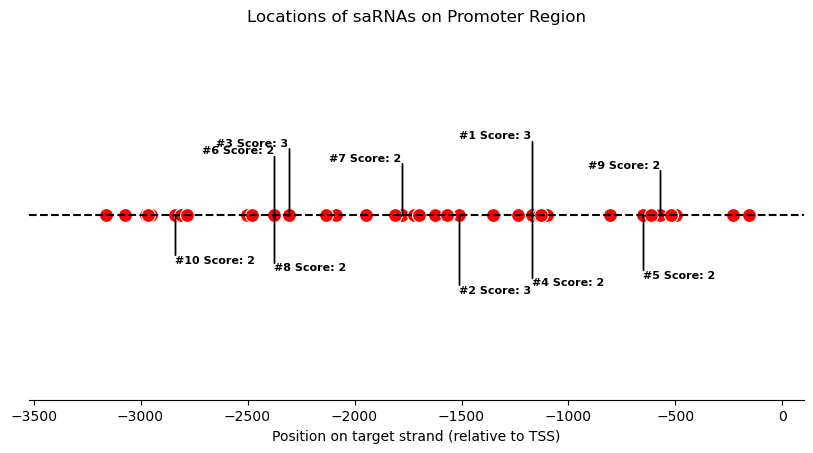

In [15]:
sequence = input('Input promoter sequence of interest:')
print("")
print("Checking sequence..")
sequence = checksequence(sequence)

print("Scanning for CpG elements..")
CpGislands = CpGislanddetector(sequence)
CpGsites = CpGsitedetector(sequence)

if sequence == 'failure':
    print("")
    print("Error: your sequence is in an invalid format. Only the characters 'A', 'G', 'C', and 'T' or 'U' (uppercase or lowercase) are allowed.")
else:
    print("Generating list of potential targets..")
    alltargets = maketargets(sequence)
    i = 3
    survivors = []
    print("Validating targets..")
    while i < len(alltargets) - 4:
        flag = True

        if checkconsecutive(sequence, i):
            flag = False

        if endstability(alltargets[i]) < 0:
            flag = False

        if countGC(alltargets[i]) < 0.4 or countGC(alltargets[i]) > 0.65:
            flag = False

        if checkpos19(alltargets[i]) == False:
            flag = False

        if checkpos18(alltargets[i]) == 0:
            flag = False

        if endbase(alltargets[i]) == False:
            flag = False

        # if inisland(i, CpGislands):
        #     flag = False

        if insite(i, CpGsites):
            flag = False

        if flag:
            survivors = survivors + [[i, alltargets[i]]]

        i = i + 1

    i = 0

    survivorscores = []
    print("Ranking target sequences..")
    while i < len(survivors):
        stabilitydiff = endstability(survivors[i][1])
        indicator18 = checkpos18(survivors[i][1])
        indicator7 = checkpos7(survivors[i][1])
        flankscore = checkflanks(sequence, survivors[i][0])
        # This is the formula that assigns desirability weights to each potential
        # target.
        score = stab * stabilitydiff + ind18 * indicator18 + ind7 * indicator7 + flank * flankscore
        survivorscores = survivorscores + [score]

        i = i + 1

    if len(survivors) != len(survivorscores):
        print("Error: scoring proceeded incorrectly for an unknown reason.")

    i = 0
    while i < len(survivors):
        comp = complement(survivors[i][1])
        survivors[i] = survivors[i] + [survivorscores[i]] + [comp]
        i = i + 1

    sortedsurvivors = sorted(survivors, key=lambda survivors: survivors[2])

    # specificity = []  # List to store specificity information for each target
    print("Number of selected saRNAs:", len(sortedsurvivors))

    print("Writing output to file..")
    output = open(filepath + '\\dsRNA_Candidates_Promoter_' + promotername + '.txt', 'w')

    if len(sortedsurvivors) == 0:
        output.write('No valid targets were detected in this promoter.')

    i = len(sortedsurvivors) - 1
    for i, target in enumerate(sortedsurvivors):
        output.write('-------------------- dsRNA ' + str(len(sortedsurvivors) - i) + ' ---------------------\n\n')
        output.write('Position on target strand: ' + str(target[0] + 1) + '\n')
        output.write('Overall score: ' + str(target[2]) + '\n\n')
        output.write('Guide strand         3\' UU' + target[3] + '    5\'\n')
        output.write('                          |||||||||||||||||||\n')
        output.write('Passenger strand     5\'   ' + target[1] + 'UU  3\'\n\n\n')
    output.close()
    
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating figure...")

if len(sortedsurvivors) == 0:
    output.write('No valid targets were detected in this promoter.')
else:
    # Prepare data for plot
    positions = [-target[0] for target in sortedsurvivors]
    scores = [round(target[2], 2) for target in sortedsurvivors]
    labels = [f"#{len(sortedsurvivors) - i} Score: {str(int(score))[0]}" for i, score in enumerate(scores)]

    # Sort the positions and labels based on scores
    sorted_data = sorted(zip(positions, labels, scores), key=lambda x: x[2], reverse=True)
    positions, labels, scores = zip(*sorted_data)

    # Take the top ten positions, labels, and scores
    top_positions = positions[:10]
    top_labels = labels[:10]
    top_scores = scores[:10]

    # Create scatter plot for saRNA markers
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(x=positions, y=[0] * len(positions), color='red', s=100, ax=ax)

    # Set plot limits and axis properties
    ax.set_xlim([-len(sequence) - 100, 100])
    ax.set_ylim([-1, 1])
    ax.set_xlabel("Position on target strand (relative to TSS)")
    ax.set_ylabel("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])

    # Add horizontal line representing the promoter region
    ax.axhline(y=0, color='black', linestyle='--')

    # Determine label positions and arrows
    arrow_direction = 'right'  # Starting direction of the arrow
    for pos, label, score in zip(top_positions, top_labels, top_scores):
        # Calculate arrow length based on the score
        arrow_length = 0.2 + 0.02 * (10 - top_positions.index(pos))

        if arrow_direction == 'right':
            ax_text = ax.text(pos, arrow_length, label, ha='right', va='bottom', fontsize=8, weight='bold')
            arrow_pos = pos
            arrow_direction = 'left'
        else:
            ax_text = ax.text(pos, -arrow_length, label, ha='left', va='top', fontsize=8, weight='bold')
            arrow_pos = pos
            arrow_direction = 'right'

        # Add arrow
        arrow_tip = arrow_length if arrow_direction == 'left' else -arrow_length
        ax.arrow(arrow_pos, arrow_tip, 0, -arrow_tip,
                 head_width=15, head_length=0, fc='black', ec='black')

    # Set plot title
    ax.set_title("Locations of saRNAs on Promoter Region")

    # Adjust spacing to avoid overlapping with the title
    plt.subplots_adjust(top=0.85)

    # Show the plot
    plt.show()



In [13]:
# Enter the promoter sequence here
seq ="""AGGCAATCTAGTCTCATAGCCTTCATTTCTTCCCTTGTCAAATTATCAATATTACATAGTTCTTACATTCCTGAAGTACTGCTTAGCAAAGTAAGTACTACCTCTCTATAATAAGTTGACCTCTAGGTACGTAGATAAAAGAGAAGAGTTACAAGCACAAGTGGAGCCACTTTGTAGATCATCTGGATTTTTCAGACACGTGTGCACCAAGAGTAAGTCTCTTTCTACAGCCTACCCTAAGCCAGAGAAACACAAACGGAGCTGTAAATTCCGCTTAATTGACATTTCAGAATTTCAAAGGGAAGTAATTGCGTCCCTGAGCTTCTCTGCACTGATCCAGAGTGGGACACATCTCAGCCCATGGATTGCTGTGGTTCTCTTTCTTTCCCTGCACTCTTTCTCCCCCTCCCACTCTTCCAAGTCAGATCAGGCCTTCTTGCTGAAGGGGAATGGAAAGGAGTACCTGGCGGATTTCATCTTCTTCACCTAACCTGGAGGGAGAGGACAACTTGGATAGAACTTGGCATGCCTGGTTTTACTGCCGTGGCCCCCGAGGACTACCCAGATCTCCGCTGTCCACAGAGAATGGAAATTAAATTCAGGCTAACTTTCATCATCAGGAACACTCAGATAATGTGTTCTGATCATCATGTGCCTGTGTGTGTGTCAATTTTGAGCAACTCTCCACGAGAGAAGGCTTCTCAGTGGAATGGAGTCCTGAGTTTCTGGTCCTTGGGTTGTGTCCTTCTGTCTGTCCACTTGCTCCTGATCTTTTTGGATGGGAAGGCAGATTGTTTGCTCTTCTCCCCAGTGCCTTCTTGGATACTGTATAATTAATTAGGCCTCCAATCATGCCTTCCCAGCCTCCACGGATGGAGAAACCCTCTCCGCCATGCCTTAAAGAGGAATTGCTGTAATAAATGAGTCTCCTGATAGCAAATTTCTCAGCAAGGGGGAATCGCGTAAATGGAGACATAGTATTGACAGCAAAGTCCAATGTGTTATTTTTACCAGAACGAACTCTCCGGTTCAAGCCTTTGAAAGAGACATTTGAAAACCAAAAACAAACAATGTAATGGAGCGAGGAAAAAAGCCACAGAAGTGAGTGGCAGGGAGTTTAAAAGAGCAGATGCCACTGCCAGGTCTATGGGACATAACCAGCCACTTGTGCTGGGTCTTGGCAGTTTATAATGCTACCTCATCTTCTCCGCGAAATTGTTTTCCCGTAAATCTCTGTGGCCATCCATTCCTGTCTACACATTATGTTCCTAAAATAGACACCATCTAAAAATCACTTCAAGGAGCTTTGTGGAGGAAGGCCTAAATTGCAACACTCCTCCAGCGAAGATAGATGCAGTGTTTGATGGCATTACCAGTCGGTAGCCAGGAAGGGGAGTTTGTGAGGAGTTTTTCCACCACAGTTAATCTGTTTCTGGAAGGAAAGGGAAGTGTCAGACTTCCCGAGGAGGCAAACGTGTGTGGAAGCTCTCATTTGCATCACCCCCGGCCTGTCAGGTATTGCAGCAAAAGGGAGAGGTGAGCTACCCTGGCTCTCCTTGGGCAGGAGGGACAGAATCAGGAAGCATCAACCTCAGCATGGAATTTTCCTATTCCTGTTTGGCATCCTCCTCTTGGGATGATTTACAGCGCGGGTTGGAGAAACACGCTCTGCCACTCCACTAGCGCACCAGATAGACAGTGCAGACCTGCAGATCCATACCCGAGGAGAAGCCACATTTCCTACGTGTGATAGCAACAGCGTTTGGCAATTTGCGACTTTGCTACTGCAGCTTAGAAAATATTTAGTCACATGCACATCTGAACAGAAAGACACCCAGGCTTGACTCAGTCATTTCCGTCAGACACACGAAAGAAAAAGCGTCTCTGCTCACAAGCTTATTTGGACTGCTTTGTTGAAAGGAGGGGCGGCAGACACTTTGTAGATGTGGCAAGAGGGCTTTATATCCAGACCTCAAACAGGTAGGAGAGAAGGAAGCCAGGAGAGGTAAGGAAGGGGCGTGGAAAAGCCTCACAGCCACCTCGAAGAAAACAGTTTTTTTGCCCTGTTCAGAAAGCAAGAGGTTCCACAGTGGTTTTGTGTCAATGGAGCACATCTGCAGTATCATTGCCGTTGGTGACCTCTGTCTAATTAAAAGTAAGTCAGTCCTTCCCACCCGGCATTGTCTGAAACCCGGGACTCTTTATCACTTTGCTAAAGTTCATTTGCAAGTGTAGTTAAGGAAGAGTCAGGGGGGAAACAGCATCTGTCCCTTCTGGTCCTGGGGAGGAGGCACTCCTTTCCAAGAGTCAAGCCTCTGCCCAAAGAAGCTGCCTCCCCTGCAATGCTAGGATCCAGGAGCAGCCCCGCTGCCTTCTTGCTTCCTCTGTGAGGTCTAATTTTTGCATCATCTTTAGGAGCGATATGACCTCTATTCACAGCCATCGAATCCAGTTCCAAAGCACCAATGACAGAGGGGGCTTCAAGACAAGACCTTGCCTAGGAGGATGCAGGCAAGCAAAGGCAAGAGCTGGCCCGATGCCAAGTTATTTTAGGCCAAAGAATCTCATCCTTCTATCAAAATGCTGAACTGCAAAACGAACCTGATTTCAGTTCATGGAAGGTTGAGAGGAGGAGGAGGGGGAGGGGAGGAGGAGGAAGAGAGGAGGAGGGGAGGAGGAGGGAGGAGGAGGAGGGGAGGAGGAGGGGGACAGTTGGTCCGAATTCACATGCAAAAATAGACTTCCTGTTCTGCCCCAACTCTTATTTCCGTGGGCTCTTCTCCCCAAGGATTTACCAGGTAAGAATTCACCACCAAAGAAGATCACAATGAGATAATCAGATGGCTTACCTGATAAAAAGGAAAATTATCCATCTGCAGTGAGGAGCAACATCTCCCCACGACGAGTCCGCACCTTCCGTTGCAACGATTCAGATTCCTTCTTGCAAAAGGTGACCAAGTGCTTCACAAGGGCTGCAGCCTCATAGGGGCAGAACACACGTACACAAACACACGCACACACACACACACATGCACCAGAGACCTCTGCAGTATCCTCTCGGCTTCATCCTCGCCTCACTCTATGGTACCTAATACAAATCAGCAAATAGCTTGTTTTAAAAAAAAAAGAAAGAAAAAAAAGCGGAGACAGCACCTAACGTTACAGTGCCATCTAGTGGCTACATCGTAAATAGGTTCTCACAGCCTGGATTTCTGTGTTCTTTCTCAACCGCTTCCTTCTGGTTCCTTTTTCTTTTTTCCTCTTTATTTTGGTTTTATTACTTCCTCAGATGCCTTTTTTTCATTCCCCTTTGCTCTGCCTATCATGGAACTATTGACTTAAAGATTAAAACAATCAGAACTGGAGAGCGTTGCTTTTAAGTTAAAAAAAAAAAGGTGCTAATTTTGTTTGTAAATGTTACT"""

In [14]:
# Copy the output of this cell in the cell that produces the output files
seq2 = seq.replace(" ", "").replace("\n", ""); print(seq2)

AGGCAATCTAGTCTCATAGCCTTCATTTCTTCCCTTGTCAAATTATCAATATTACATAGTTCTTACATTCCTGAAGTACTGCTTAGCAAAGTAAGTACTACCTCTCTATAATAAGTTGACCTCTAGGTACGTAGATAAAAGAGAAGAGTTACAAGCACAAGTGGAGCCACTTTGTAGATCATCTGGATTTTTCAGACACGTGTGCACCAAGAGTAAGTCTCTTTCTACAGCCTACCCTAAGCCAGAGAAACACAAACGGAGCTGTAAATTCCGCTTAATTGACATTTCAGAATTTCAAAGGGAAGTAATTGCGTCCCTGAGCTTCTCTGCACTGATCCAGAGTGGGACACATCTCAGCCCATGGATTGCTGTGGTTCTCTTTCTTTCCCTGCACTCTTTCTCCCCCTCCCACTCTTCCAAGTCAGATCAGGCCTTCTTGCTGAAGGGGAATGGAAAGGAGTACCTGGCGGATTTCATCTTCTTCACCTAACCTGGAGGGAGAGGACAACTTGGATAGAACTTGGCATGCCTGGTTTTACTGCCGTGGCCCCCGAGGACTACCCAGATCTCCGCTGTCCACAGAGAATGGAAATTAAATTCAGGCTAACTTTCATCATCAGGAACACTCAGATAATGTGTTCTGATCATCATGTGCCTGTGTGTGTGTCAATTTTGAGCAACTCTCCACGAGAGAAGGCTTCTCAGTGGAATGGAGTCCTGAGTTTCTGGTCCTTGGGTTGTGTCCTTCTGTCTGTCCACTTGCTCCTGATCTTTTTGGATGGGAAGGCAGATTGTTTGCTCTTCTCCCCAGTGCCTTCTTGGATACTGTATAATTAATTAGGCCTCCAATCATGCCTTCCCAGCCTCCACGGATGGAGAAACCCTCTCCGCCATGCCTTAAAGAGGAATTGCTGTAATAAATGAGTCTCCTGATAGCAAATTTCTCAGCAAGGGGGAATCGCGTAAATGGAGACATAGTATTGACAGCAAAGTCCAATGT

In [28]:
import time
from tqdm import tqdm
from Bio.Blast import NCBIWWW, NCBIXML

print("Performing BLAST search...")
start_time = time.time()

if len(sortedsurvivors) == 0:
    output.write('No valid targets were detected in this promoter.')
else:
    # Prepare data for BLAST search
    dsRNA_sequences = [f"#{len(sortedsurvivors) - i} dsRNA: {target[3]} {target[1]} UU (Score: {target[2]})" for i, target in enumerate(sortedsurvivors)]
    top_dsRNA_sequences = dsRNA_sequences[-5:][::-1]  # Get top 5 dsRNAs with highest scores in descending order

    # Perform BLAST search for the top 5 dsRNAs with highest scores
    for i, dsRNA_sequence in enumerate(tqdm(top_dsRNA_sequences, desc="Blast progress")):
        # Extract the converted passenger strand and convert to DNA
        sequence = sortedsurvivors[-i-1][1][:23]  # Update to include the first two nucleotides
        dna_sequence = sequence.replace('U', 'T')

        # Perform BLAST search with filtering parameters against genomic/9606/RefSeqGene dataset
        result_handle = NCBIWWW.qblast("blastn", "genomic/9606/RefSeqGene", dna_sequence, expect=1)

        # Parse the BLAST search results
        blast_records = NCBIXML.parse(result_handle)
        matched_entries = []
        for blast_record in blast_records:
            # Extract the matched entry names, descriptions, E-values, and calculate query coverage
            for alignment in blast_record.alignments:
                entry_name = alignment.title.split("|")[4].strip()
                entry_description = alignment.title.split("|")[-1].strip()
                for hsp in alignment.hsps:
                    e_value = hsp.expect
                    alignment_length = hsp.align_length
                    query_coverage = (hsp.query_end - hsp.query_start + 1) / alignment_length * 100

                    if e_value <= 0.5:  # Add filter condition for E-value
                        matched_entries.append((entry_name, entry_description, e_value, query_coverage))

        result_handle.close()

        dsRNA_index = len(sortedsurvivors) - i  # Calculate the dsRNA index for correct numbering

        print(f"Matched entries for dsRNA {dsRNA_index}:")
        if len(matched_entries) == 0:
            print("No matched entries found.")
        else:
            print(f"Number of matched entries: {len(matched_entries)}")

            for entry_name, entry_description, e_value, query_coverage in matched_entries:
                print(f"{entry_name}: {entry_description}")
                print(f"E-value: {e_value}")
                print(f"Query Coverage: {query_coverage:.2f}%")
                print()

        print(f"\n{dsRNA_sequence}\n")  # Print dsRNA sequence
        print(f"BLAST search sequence: {dna_sequence}\n")  # Print BLAST search sequence

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Performing BLAST search...


Blast progress:  20%|██        | 1/5 [03:01<12:07, 181.98s/it]

Matched entries for dsRNA 34:
Number of matched entries: 1
Homo sapiens IQ motif containing B1 (IQCB1), RefSeqGene on chromosome 3: Homo sapiens IQ motif containing B1 (IQCB1), RefSeqGene on chromosome 3
E-value: 0.47661
Query Coverage: 100.00%


#1 dsRNA: CGUCAGAUGUUCCGACUUU GCAGUCUACAAGGCUGAAA UU (Score: 3003.0696)

BLAST search sequence: GCAGTCTACAAGGCTGAAA



Blast progress:  40%|████      | 2/5 [03:21<04:19, 86.67s/it] 

Matched entries for dsRNA 33:
Number of matched entries: 3
Homo sapiens OFD1 centriole and centriolar satellite protein (OFD1), RefSeqGene on chromosome X: Homo sapiens OFD1 centriole and centriolar satellite protein (OFD1), RefSeqGene on chromosome X
E-value: 0.47661
Query Coverage: 100.00%

Homo sapiens interleukin 12 receptor subunit beta 2 (IL12RB2), RefSeqGene (LRG_707) on chromosome 1: Homo sapiens interleukin 12 receptor subunit beta 2 (IL12RB2), RefSeqGene (LRG_707) on chromosome 1
E-value: 0.47661
Query Coverage: 100.00%

Homo sapiens trafficking protein particle complex subunit 2 (TRAPPC2), RefSeqGene on chromosome X: Homo sapiens trafficking protein particle complex subunit 2 (TRAPPC2), RefSeqGene on chromosome X
E-value: 0.47661
Query Coverage: 100.00%


#2 dsRNA: GUCGUAAGGUUCAAGACUU CAGCAUUCCAAGUUCUGAA UU (Score: 3003.0513)

BLAST search sequence: CAGCATTCCAAGTTCTGAA



Blast progress:  60%|██████    | 3/5 [06:41<04:36, 138.08s/it]

Matched entries for dsRNA 32:
Number of matched entries: 1
Homo sapiens gamma-aminobutyric acid type A receptor subunit gamma2 (GABRG2), RefSeqGene on chromosome 5: Homo sapiens gamma-aminobutyric acid type A receptor subunit gamma2 (GABRG2), RefSeqGene on chromosome 5
E-value: 0.47661
Query Coverage: 100.00%


#3 dsRNA: CAGUAUAGACCCUCUGUUU GUCAUAUCUGGGAGACAAA UU (Score: 3003.0297)

BLAST search sequence: GTCATATCTGGGAGACAAA



Blast progress:  80%|████████  | 4/5 [13:01<03:53, 233.91s/it]

Matched entries for dsRNA 31:
Number of matched entries: 1
Homo sapiens proline rich and Gla domain 1 (PRRG1), RefSeqGene on chromosome X: Homo sapiens proline rich and Gla domain 1 (PRRG1), RefSeqGene on chromosome X
E-value: 0.47661
Query Coverage: 100.00%


#4 dsRNA: GGUCCUAAGAUCUUACCUU CCAGGAUUCUAGAAUGGAA UU (Score: 3002.0186000000003)

BLAST search sequence: CCAGGATTCTAGAATGGAA



Blast progress: 100%|██████████| 5/5 [14:21<00:00, 172.30s/it]

Matched entries for dsRNA 30:
No matched entries found.

#5 dsRNA: GGUACUAUCCGUCUCGUUU CCAUGAUAGGCAGAGCAAA UU (Score: 3000.0281)

BLAST search sequence: CCATGATAGGCAGAGCAAA

Execution time: 861.53 seconds


In [80]:
sarna10 = "CUUAACUCGCCUUCCAAAA"
saRev ="AAAACCUUCCGCUCAAUUC"

In [81]:
print(endstability(sarna10))
print(endstability(saRev))

-0.6199999999999992
-0.5500000000000007


In [82]:
print(endbase(sarna10))
print(endbase(saRev))

True
False


In [29]:
#Blast on mouse genome:
import time
from tqdm import tqdm
from Bio.Blast import NCBIWWW, NCBIXML

print("Performing BLAST search...")
start_time = time.time()

if len(sortedsurvivors) == 0:
    output.write('No valid targets were detected in this promoter.')
else:
    # Prepare data for BLAST search
    dsRNA_sequences = [f"#{len(sortedsurvivors) - i} dsRNA: {target[3]} {target[1]} UU (Score: {target[2]})" for i, target in enumerate(sortedsurvivors)]
    top_dsRNA_sequences = dsRNA_sequences[-5:][::-1]  # Get top 5 dsRNAs with highest scores in descending order

    # Perform BLAST search for the top 5 dsRNAs with highest scores
    for i, dsRNA_sequence in enumerate(tqdm(top_dsRNA_sequences, desc="Blast progress")):
        # Extract the converted passenger strand and convert to DNA
        sequence = sortedsurvivors[-i-1][1][:23]  # Update to include the first two nucleotides
        dna_sequence = sequence.replace('U', 'T')

        # Perform BLAST search with filtering parameters against mouse genomic database
        result_handle = NCBIWWW.qblast("blastn", "nr", dna_sequence, expect=1, entrez_query="txid10090[ORGN]")

        # Parse the BLAST search results
        blast_records = NCBIXML.parse(result_handle)
        matched_entries = []
        for blast_record in blast_records:
            # Extract the matched entry names, descriptions, E-values, and calculate query coverage
            for alignment in blast_record.alignments:
                entry_name = alignment.title.split("|")[4].strip()
                entry_description = alignment.title.split("|")[-1].strip()
                for hsp in alignment.hsps:
                    e_value = hsp.expect
                    alignment_length = hsp.align_length
                    query_coverage = (hsp.query_end - hsp.query_start + 1) / alignment_length * 100

                    if e_value <= 0.5:  # Add filter condition for E-value
                        matched_entries.append((entry_name, entry_description, e_value, query_coverage))

        result_handle.close()

        dsRNA_index = len(sortedsurvivors) - i  # Calculate the dsRNA index for correct numbering

        print(f"Matched entries for dsRNA {dsRNA_index}:")
        if len(matched_entries) == 0:
            print("No matched entries found.")
        else:
            print(f"Number of matched entries: {len(matched_entries)}")

            for entry_name, entry_description, e_value, query_coverage in matched_entries:
                print(f"{entry_name}: {entry_description}")
                print(f"E-value: {e_value}")
                print(f"Query Coverage: {query_coverage:.2f}%")
                print()

        print(f"\n{dsRNA_sequence}\n")  # Print dsRNA sequence
        print(f"BLAST search sequence: {dna_sequence}\n")  # Print BLAST search sequence

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Performing BLAST search...


Blast progress:  20%|██        | 1/5 [01:01<04:06, 61.70s/it]

Matched entries for dsRNA 34:
No matched entries found.

#1 dsRNA: CGUCAGAUGUUCCGACUUU GCAGUCUACAAGGCUGAAA UU (Score: 3003.0696)

BLAST search sequence: GCAGTCTACAAGGCTGAAA



Blast progress:  40%|████      | 2/5 [06:21<10:40, 213.64s/it]

Matched entries for dsRNA 33:
No matched entries found.

#2 dsRNA: GUCGUAAGGUUCAAGACUU CAGCAUUCCAAGUUCUGAA UU (Score: 3003.0513)

BLAST search sequence: CAGCATTCCAAGTTCTGAA



Blast progress:  60%|██████    | 3/5 [13:41<10:34, 317.00s/it]

Matched entries for dsRNA 32:
No matched entries found.

#3 dsRNA: CAGUAUAGACCCUCUGUUU GUCAUAUCUGGGAGACAAA UU (Score: 3003.0297)

BLAST search sequence: GTCATATCTGGGAGACAAA



Blast progress:  80%|████████  | 4/5 [18:02<04:54, 294.81s/it]

Matched entries for dsRNA 31:
No matched entries found.

#4 dsRNA: GGUCCUAAGAUCUUACCUU CCAGGAUUCUAGAAUGGAA UU (Score: 3002.0186000000003)

BLAST search sequence: CCAGGATTCTAGAATGGAA



Blast progress: 100%|██████████| 5/5 [18:21<00:00, 220.34s/it]

Matched entries for dsRNA 30:
No matched entries found.

#5 dsRNA: GGUACUAUCCGUCUCGUUU CCAUGAUAGGCAGAGCAAA UU (Score: 3000.0281)

BLAST search sequence: CCATGATAGGCAGAGCAAA

Execution time: 1101.73 seconds


In [1]:
len("GGGAUGUGGCAGUAUGCAA")

19